In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
%matplotlib inline

In [2]:
#TEMPERATURE DATA 1909 - 2013
temp_data = pd.read_csv("annual-average-temperature-anomaly-19092013.csv")
temp_data = temp_data[temp_data.data=="Temp"]
temp_data = temp_data.rename({'value': 'temp'}, axis=1)
del temp_data['series']


#suitable years between 1986 & 2013 - also deals with nans
for i,j in temp_data.iterrows():
    if int(temp_data.loc[i]['Year']) < 1986:
        temp_data.drop(i, inplace = True)
#print(np.unique(temp_data.temp)) - contains no Nans


#print(np.unique(temp_data.station))
AuckTemp = temp_data[temp_data.station == "Auckland"]
DuneTemp = temp_data[temp_data.station == "Dunedin"]
HokiTemp = temp_data[temp_data.station == "Hokitika"]
MastTemp = temp_data[temp_data.station == "Masterton"]
NelsTemp = temp_data[temp_data.station == "Nelson"]
WellTemp = temp_data[temp_data.station == "Wellington"]
CompTemp = temp_data[temp_data.station == "7_Stn_Composite"]

#np.unique(CompTemp.temp)
#AuckTemp.info()


In [3]:
#ENSO DATA 1986 - 2016 - already no nans
oscillation_data = pd.read_csv("monthly-el-nino-southern-oscillation-index-19862016.csv")
oscillation_data = oscillation_data.rename({'Southern_oscillation_index': 'SOI'}, axis=1)
years = []
months = []


#iterate and repair year and date columns
for r in oscillation_data.iterrows():
    yearval = int(str((r[1][0])).split("-")[1])
    if yearval > 80:
        yearval = str(19)+ str(yearval)
    elif yearval < 10:
        yearval = str(200)+ str(yearval)
    else:
        yearval = str(20)+ str(yearval)
    years.append(yearval)
    months.append(str((r[1][0])).split("-")[0])

oscillation_data["Year"] = years
oscillation_data["month"] = months

#remove out of bounds years
for i,j in oscillation_data.iterrows():
    if int(oscillation_data.loc[i]['Year']) > 2013:
        oscillation_data.drop(i, inplace = True)


#np.unique(oscillation_data.month)

#Single row per year - in new dataframe - still may need months
osc_year = oscillation_data.groupby('Year').agg('mean')
osc_year.reset_index(level=0, inplace=True)
#osc_year.info()

In [4]:
#RAINFALL DATA1962-2016
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

rainfall_data = pd.read_csv("rainfall-19602016.csv")
rainfall_data.head()
#np.unique(rainfall_data.Rainfall_mm)#some nans
#np.unique(rainfall_data.Date)#some nans
months = []
years = []
rainfall_data = rainfall_data.rename({'Rainfall_mm': 'rain'}, axis=1)
rainfall_data = rainfall_data[rainfall_data['Date'].notna()]#no date, cant get average date - drop



#get years and months form date - remove years outside of ENSO dataset
rainfall_data['day'], rainfall_data['month'], rainfall_data['Year']= rainfall_data['Date'].str.split('/', 2).str
rainfall_data["Year"] = pd.to_numeric(rainfall_data["Year"])
#should throw error if missing data
rainfall_data = rainfall_data.loc[rainfall_data.loc[:, 'Year'].between(1986, 2013), : ]

#convert years back to string

#rainfall_data.Year = rainfall_data.Year.round()
#print(rainfall_data.info())
rainfall_data["Year"] = rainfall_data["Year"].astype(int)#remove .0 from year year
rainfall_data['Year'] = rainfall_data["Year"].apply(str)

#replace missing rain values with mean - no nans for the main six cities after year range adjusted
rainfall_data['rain'].fillna((rainfall_data['rain'].mean()), inplace=True)

#Get sets of cities - 
AuckRain = rainfall_data[rainfall_data.site == "Auckland"].groupby('Year').agg('mean')
DuneRain = rainfall_data[rainfall_data.site == "Dunedin"].groupby('Year').agg('mean')
HokiRain = rainfall_data[rainfall_data.site == "Hokitika"].groupby('Year').agg('mean')
MastRain = rainfall_data[rainfall_data.site == "Masterton"].groupby('Year').agg('mean')
NelsRain = rainfall_data[rainfall_data.site == "Nelson"].groupby('Year').agg('mean')
WellRain = rainfall_data[rainfall_data.site == "Wellington"].groupby('Year').agg('mean')

#np.unique(WellRain.rain)#no nans in any city for rain data
#AuckRain

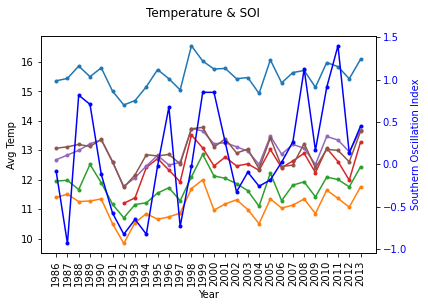

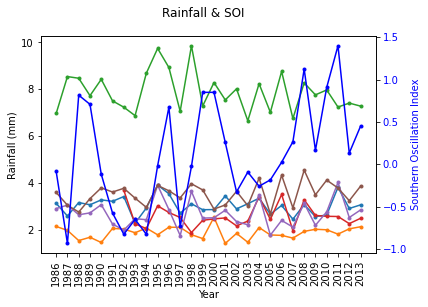

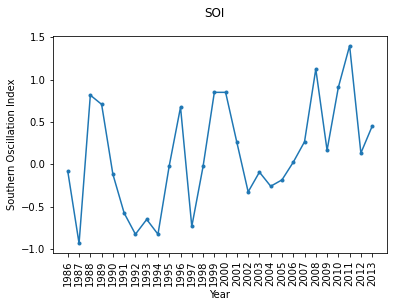

In [5]:
#JOINING BY YEAR - Now cotains single row row year with avg tempa and rainfall. Also contains SOI
AuckMerge = AuckRain.join(AuckTemp.set_index('Year'),on='Year',how='left',rsuffix='_y').join(osc_year.set_index('Year'),on='Year',how='left',rsuffix='_y')

DuneMerge = DuneRain.join(DuneTemp.set_index('Year'),on='Year',how='left',rsuffix='_y').join(osc_year.set_index('Year'),on='Year',how='left',rsuffix='_y')

HokiMerge = HokiRain.join(HokiTemp.set_index('Year'),on='Year',how='left',rsuffix='_y').join(osc_year.set_index('Year'),on='Year',how='left',rsuffix='_y')

#Masterton only from 1992 - still ok for time series
MastMerge = MastRain.join(MastTemp.set_index('Year'),on='Year',how='left',rsuffix='_y').join(osc_year.set_index('Year'),on='Year',how='left',rsuffix='_y')

NelsMerge = NelsRain.join(NelsTemp.set_index('Year'),on='Year',how='left',rsuffix='_y').join(osc_year.set_index('Year'),on='Year',how='left',rsuffix='_y')

WellMerge = WellRain.join(WellTemp.set_index('Year'),on='Year',how='left',rsuffix='_y').join(osc_year.set_index('Year'),on='Year',how='left',rsuffix='_y')



#temp #rain #SOI


#PLOT ALL TEMP and SOI

fig, ax1 = pl.subplots()
fig.suptitle('Temperature & SOI')
ax1.set_xlabel('Year')
ax1.set_ylabel('Avg Temp')
pl.xticks(rotation=90)
ax1.plot(AuckMerge.index[:], AuckMerge.temp[:], '.-')
ax1.plot(DuneMerge.index[:], DuneMerge.temp[:], '.-')
ax1.plot(HokiMerge.index[:], HokiMerge.temp[:], '.-')
ax1.plot(MastMerge.index[:], MastMerge.temp[:], '.-')
ax1.plot(NelsMerge.index[:], NelsMerge.temp[:], '.-')
ax1.plot(WellMerge.index[:], WellMerge.temp[:], '.-')

ax2 = ax1.twinx()
ax2.set_ylabel('Southern Oscillation Index', color='blue') 
ax2.tick_params(axis='y', labelcolor="blue")
ax2.plot(osc_year.index[:], osc_year.SOI[:], 'b.-')

# #PLOT ALL RAINFALL and SOI
fig, ax1 = pl.subplots()
fig.suptitle('Rainfall & SOI')
ax1.set_xlabel('Year')
ax1.set_ylabel('Rainfall (mm)')
pl.xticks(rotation=90)
ax1.plot(AuckMerge.index[:], AuckMerge.rain[:], '.-')
ax1.plot(DuneMerge.index[:], DuneMerge.rain[:], '.-')
ax1.plot(HokiMerge.index[:], HokiMerge.rain[:], '.-')
ax1.plot(MastMerge.index[:], MastMerge.rain[:], '.-')
ax1.plot(NelsMerge.index[:], NelsMerge.rain[:], '.-')
ax1.plot(WellMerge.index[:], WellMerge.rain[:], '.-')

ax2 = ax1.twinx()
ax2.set_ylabel('Southern Oscillation Index', color='blue') 
ax2.tick_params(axis='y', labelcolor="blue")
ax2.plot(osc_year.index[:], osc_year.SOI[:], 'b.-')

fig, ax1 = pl.subplots()
fig.suptitle('SOI')
ax1.set_xlabel('Year')
ax1.set_ylabel('Southern Oscillation Index')
pl.xticks(rotation=90)
ax1.plot(osc_year.Year[:], osc_year.SOI[:], '.-')

Temporal pattern does appear to exist in ENSO data, varying sized peaks every ~2-7 years.

In [6]:
#7 station comp used(means for years)
rain_med_year = rainfall_data.groupby('Year').agg('mean')#contains some nans in non tested cities, average value used
rain_med_year.reset_index(level=0, inplace=True)
NZ_year_avgs = CompTemp.join(rain_med_year.set_index('Year'),on='Year',how='left',rsuffix='_y').join(osc_year.set_index('Year'),on='Year',how='left',rsuffix='_y')
NZ_year_avgs
print("All Data")
print(NZ_year_avgs[(['temp', 'rain','SOI'])].corr())


All Data
          temp      rain       SOI
temp  1.000000  0.051882  0.565552
rain  0.051882  1.000000  0.236053
SOI   0.565552  0.236053  1.000000


The data in the above matrix uses average yearly temperature and rainfall measurements for all locations.
A correlation positive correlation between southern oscillation index (SOI) and temperature (0.57, 2dp). A weak-moderate positive association between SOI and rain (0.24, 2dp). Weak-no positive correlation  between temperature and rain.

In [7]:
print("Auckland")
print(AuckMerge[(['temp', 'rain','SOI'])].corr())
print("\nDunedin")
print(DuneMerge[(['temp', 'rain','SOI'])].corr())
print("\nHokitika")
print(HokiMerge[(['temp', 'rain','SOI'])].corr())
print("\nMasterton")
print(MastMerge[(['temp', 'rain','SOI'])].corr())
print("\nNelson")
print(NelsMerge[(['temp', 'rain','SOI'])].corr())
print("\nWellington")
print(WellMerge[(['temp', 'rain','SOI'])].corr())

Auckland
          temp      rain       SOI
temp  1.000000  0.107158  0.586845
rain  0.107158  1.000000  0.238533
SOI   0.586845  0.238533  1.000000

Dunedin
          temp      rain       SOI
temp  1.000000 -0.269426  0.481875
rain -0.269426  1.000000 -0.108965
SOI   0.481875 -0.108965  1.000000

Hokitika
          temp      rain       SOI
temp  1.000000 -0.036544  0.606439
rain -0.036544  1.000000  0.043338
SOI   0.606439  0.043338  1.000000

Masterton
          temp      rain       SOI
temp  1.000000 -0.310105  0.536940
rain -0.310105  1.000000  0.012065
SOI   0.536940  0.012065  1.000000

Nelson
          temp      rain       SOI
temp  1.000000  0.269401  0.570580
rain  0.269401  1.000000  0.362753
SOI   0.570580  0.362753  1.000000

Wellington
          temp      rain       SOI
temp  1.000000 -0.067386  0.448135
rain -0.067386  1.000000  0.198821
SOI   0.448135  0.198821  1.000000


The Auckland, Hokitika and Nelson regions have the greatest correlation (Positive medium) (0.59, 0.61 and 0.57 respectively)between SOI and temperature. The remaining regions have slightly weaker, but still moderate correlation between SOI and temp - but these are lower than the value found for the nationwide data.
Only the Nelson region has a great correlation between rain and SOI than the whoe country data (0.36, positive moderate).
Regions Auckland, Dunedin, Masterton and Nelson both have more substantial correlations between temp and rain, all still weak-moderate. Dunedin and Masterton actaully have negative correlations for this.

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
#drop un-needed values
AuckMergeInts = AuckMerge.drop(["station", "data"], axis=1) \

#divide in test and training
train_set, test_set = train_test_split(AuckMergeInts, test_size=0.2, random_state=42)

X_train = train_set.drop("SOI", axis=1)
y_train = train_set["SOI"].copy()

X_test = test_set.drop("SOI", axis=1)
y_test = test_set["SOI"].copy()


#scale
scaler = StandardScaler()
X_train_scaled  = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Here the Auckland regional, yearly values have been split into test and training sets, and the data has also been scaled using a standard scaler. The temp and rain variables are the X variables, and SOI is y.

In [9]:
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ARDRegression
from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.metrics import mean_squared_error
classifiers = [
    svm.SVR(),
    SGDRegressor(),
    LinearRegression()]

#Quick check of some classifier options
for item in classifiers:
    print(item)
    clf = item
    clf.fit(X_train_scaled, y_train)
    print("Train RMSE: ", np.sqrt(mean_squared_error(clf.predict(X_train_scaled),y_train)))
    print("Test RMSE: ", np.sqrt(mean_squared_error(clf.predict(X_test_scaled),y_test)))
    print()

SVR()
Train RMSE:  0.35443484743456166
Test RMSE:  0.6081093247763422

SGDRegressor()
Train RMSE:  0.45599354261448455
Test RMSE:  0.6214157458351655

LinearRegression()
Train RMSE:  0.4434286483579511
Test RMSE:  0.6786195824286032



A quick test of a couple of different Regression algorithms. In all cases the test RMSE is highier than it's respective training RMSE, potentially indicating an over-fit of the model. The SGD alg is investigated further below because it had the smallest difference between test and train RMSE, and the (test) RMSE values were pretty similar for all the tests.

In [10]:
from sklearn.model_selection import GridSearchCV

import pprint as pp
SGD = SGDRegressor(random_state = 42)
grid_paramsSDG = {'penalty' : ['l1', 'l2', 'elasticnet'],
                'alpha' : [0.0001, 0.001, 0.01, 0.1, 1, 10]
                }
gridSDG = GridSearchCV(SGD, grid_paramsSDG, cv=5, n_jobs=-1, verbose=1)
gridSDG.fit(X_train_scaled, y_train) 

print("SGDRegressor")
print(gridSDG.best_score_)
print(gridSDG.best_params_)
print("Train RMSE: ", np.sqrt(mean_squared_error(gridSDG.predict(X_train_scaled),y_train)))
print("Test RMSE: ", np.sqrt(mean_squared_error(gridSDG.predict(X_test_scaled),y_test)))
#pp.pprint(sorted(gridSDG.get_params().keys())) 


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


SGDRegressor
-0.0029067969984250207
{'alpha': 0.01, 'penalty': 'l1'}
Train RMSE:  0.4582743255467673
Test RMSE:  0.6195319430335797


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    1.3s finished


Only a small improvement after gridsearch, the data set is pretty small, and only a few variables are tested.
The train RMSE is still less than the test.
The test errot of about 0.6 is pretty large compared of the range of the yearly SOI data (between about -1 and 1.5).
I would say snot very accurate predictions could be used with this model, this may be able to be improved if mroe training data was available.

In [11]:
oscillation_data

,Month_year,SOI,Year,month
0,Jan-86,1.0,1986,Jan
1,Feb-86,-1.0,1986,Feb
2,Mar-86,0.5,1986,Mar
3,Apr-86,0.3,1986,Apr
4,May-86,-0.2,1986,May
...,...,...,...,...
331,Aug-13,0.2,2013,Aug
332,Sep-13,0.3,2013,Sep
333,Oct-13,-0.1,2013,Oct
334,Nov-13,0.7,2013,Nov


In [12]:
columns = ["mon-3", "mon-2", "mon-1", "current"]
mon3 = []
mon2 = []
mon1 = []
mon = []
threeMonthENSO = pd.DataFrame(columns=columns, index=range(336-3))
for i,j in oscillation_data.iterrows():
    if i > 2:#wont use first three months
        mon3.append(oscillation_data.loc[i-3]['SOI'])
        mon2.append(oscillation_data.loc[i-2]['SOI'])
        mon1.append(oscillation_data.loc[i-1]['SOI'])
        mon.append(oscillation_data.loc[i]['SOI'])
        
threeMonthENSO["mon-3"] = mon3
threeMonthENSO["mon-2"] = mon2
threeMonthENSO["mon-1"] = mon1
threeMonthENSO["current"] = mon

#divide in test and training
train_set, test_set = train_test_split(threeMonthENSO, test_size=0.2, random_state=42)

X_train = train_set.drop("current", axis=1)
y_train = train_set["current"].copy()

X_test = test_set.drop("current", axis=1)
y_test = test_set["current"].copy()


#scale
scaler = StandardScaler()
X_train_scaled  = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


    
SVR = svm.SVR()
grid_paramSVR = {'C' : np.logspace(0, 4, 10),
                 'gamma' : ['scale', 'auto'],
                 'kernel' : ['linear', 'poly', 'rbf']
                }
gridSVR = GridSearchCV(SVR, grid_paramSVR, cv=5, n_jobs=-1, verbose=1)
gridSVR.fit(X_train_scaled, y_train) 
#pp.pprint(sorted(gridSVR.get_params().keys())) 
print("SVR")
print(gridSVR.best_score_)
print(gridSVR.best_params_)
print("Train RMSE: ", np.sqrt(mean_squared_error(gridSVR.predict(X_train_scaled),y_train)))
print("Test RMSE: ", np.sqrt(mean_squared_error(gridSVR.predict(X_test_scaled),y_test)))


SGD = SGDRegressor(random_state = 42)
grid_paramsSDG = {'penalty' : ['l1', 'l2', 'elasticnet'],
                'alpha' : [0.0001, 0.001, 0.01, 0.1, 1, 10]
                }
gridSDG = GridSearchCV(SGD, grid_paramsSDG, cv=5, n_jobs=-1, verbose=1)
gridSDG.fit(X_train_scaled, y_train) 

print("SGDRegressor")
print(gridSDG.best_score_)
print(gridSDG.best_params_)
print("Train RMSE: ", np.sqrt(mean_squared_error(gridSDG.predict(X_train_scaled),y_train)))
print("Test RMSE: ", np.sqrt(mean_squared_error(gridSDG.predict(X_test_scaled),y_test)))

LREG = LinearRegression()
grid_paramsLREG = {"n_jobs": [1,2,3],
                   "fit_intercept": [True, False]
                }

gridLREG = GridSearchCV(LREG, grid_paramsLREG, cv=5, n_jobs=-1, verbose=1)
gridLREG.fit(X_train_scaled, y_train) 

print("LinearRegression")
print(gridLREG.best_score_)
print(gridLREG.best_params_)
print("Train RMSE: ", np.sqrt(mean_squared_error(gridLREG.predict(X_train_scaled),y_train)))
print("Test RMSE: ", np.sqrt(mean_squared_error(gridLREG.predict(X_test_scaled),y_test)))

#pp.pprint(sorted(gridLREG.get_params().keys()))

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 277 out of 300 | elapsed:  1.3min remaining:    6.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.7min finished


SVR
0.5324578811743783
{'C': 10000.0, 'gamma': 'scale', 'kernel': 'linear'}
Train RMSE:  0.678226259169336
Test RMSE:  0.7572567684385775
Fitting 5 folds for each of 18 candidates, totalling 90 fits
SGDRegressor
0.5342220205875673
{'alpha': 0.01, 'penalty': 'l2'}
Train RMSE:  0.676696258805551
Test RMSE:  0.7544773895800116
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


LinearRegression
0.5321157113104458
{'fit_intercept': True, 'n_jobs': 1}
Train RMSE:  0.6764096655663925
Test RMSE:  0.7491044151314348


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.0s finished


All algorithms produced very similar RMSE for train and test. In all cases, train RMSE is larger. Best results come from LinearRegression - however this is only a very small <0.01  difference in test RMSE. RMSE is a little over 10% of the range of monthly SIO (-3 - 3), some preditions could be made using this.

In [13]:
columns = ["mon-6","mon-5","mon-4","mon-3", "mon-2", "mon-1", "current"]
mon6 = []
mon5 = []
mon4 = []
mon3 = []
mon2 = []
mon1 = []
mon = []
sixMonthENSO = pd.DataFrame(columns=columns, index=range(336-6))
for i,j in oscillation_data.iterrows():
    if i > 5:#wont use first five months
        mon6.append(oscillation_data.loc[i-6]['SOI'])
        mon5.append(oscillation_data.loc[i-5]['SOI'])
        mon4.append(oscillation_data.loc[i-4]['SOI'])
        mon3.append(oscillation_data.loc[i-3]['SOI'])
        mon2.append(oscillation_data.loc[i-2]['SOI'])
        mon1.append(oscillation_data.loc[i-1]['SOI'])
        mon.append(oscillation_data.loc[i]['SOI'])
        
sixMonthENSO["mon-6"] = mon6
sixMonthENSO["mon-5"] = mon5
sixMonthENSO["mon-4"] = mon4
sixMonthENSO["mon-3"] = mon3
sixMonthENSO["mon-2"] = mon2
sixMonthENSO["mon-1"] = mon1
sixMonthENSO["current"] = mon

#divide in test and training
train_set, test_set = train_test_split(sixMonthENSO, test_size=0.2, random_state=42)

X_train = train_set.drop("current", axis=1)
y_train = train_set["current"].copy()

X_test = test_set.drop("current", axis=1)
y_test = test_set["current"].copy()


#scale
scaler = StandardScaler()
X_train_scaled  = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

SVR = svm.SVR()
grid_paramSVR = {'C' : np.logspace(0, 4, 10),
                 'gamma' : ['scale', 'auto'],
                 'kernel' : ['linear', 'poly', 'rbf']
                }
gridSVR = GridSearchCV(SVR, grid_paramSVR, cv=5, n_jobs=-1, verbose=1)
gridSVR.fit(X_train_scaled, y_train) 
#pp.pprint(sorted(gridSVR.get_params().keys())) 
print("SVR")
print(gridSVR.best_score_)
print(gridSVR.best_params_)
print("Train RMSE: ", np.sqrt(mean_squared_error(gridSVR.predict(X_train_scaled),y_train)))
print("Test RMSE: ", np.sqrt(mean_squared_error(gridSVR.predict(X_test_scaled),y_test)))


SGD = SGDRegressor(random_state = 42)
grid_paramsSDG = {'penalty' : ['l1', 'l2', 'elasticnet'],
                'alpha' : [0.0001, 0.001, 0.01, 0.1, 1, 10]
                }
gridSDG = GridSearchCV(SGD, grid_paramsSDG, cv=5, n_jobs=-1, verbose=1)
gridSDG.fit(X_train_scaled, y_train) 

print("SGDRegressor")
print(gridSDG.best_score_)
print(gridSDG.best_params_)
print("Train RMSE: ", np.sqrt(mean_squared_error(gridSDG.predict(X_train_scaled),y_train)))
print("Test RMSE: ", np.sqrt(mean_squared_error(gridSDG.predict(X_test_scaled),y_test)))

LREG = LinearRegression()
grid_paramsLREG = {"n_jobs": [1,2,3],
                   "fit_intercept": [True, False]
                }

gridLREG = GridSearchCV(LREG, grid_paramsLREG, cv=5, n_jobs=-1, verbose=1)
gridLREG.fit(X_train_scaled, y_train) 

print("LinearRegression")
print(gridLREG.best_score_)
print(gridLREG.best_params_)
print("Train RMSE: ", np.sqrt(mean_squared_error(gridLREG.predict(X_train_scaled),y_train)))
print("Test RMSE: ", np.sqrt(mean_squared_error(gridLREG.predict(X_test_scaled),y_test)))

#pp.pprint(sorted(gridLREG.get_params().keys()))

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 277 out of 300 | elapsed:  2.1min remaining:   10.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


SVR
0.45617783033677933
{'C': 1.0, 'gamma': 'scale', 'kernel': 'linear'}
Train RMSE:  0.7017096893269966
Test RMSE:  0.6528832954455238
Fitting 5 folds for each of 18 candidates, totalling 90 fits
SGDRegressor
0.4558343154075814
{'alpha': 0.1, 'penalty': 'l2'}
Train RMSE:  0.6993728606519667
Test RMSE:  0.6496265943472418
Fitting 5 folds for each of 6 candidates, totalling 30 fits
LinearRegression
0.45291294443472124
{'fit_intercept': True, 'n_jobs': 1}
Train RMSE:  0.6970046711857081
Test RMSE:  0.6378540347512128


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.0s finished


Using 6 months, there is less difference between trian and test RMSE for all algorithms tested, also generally slighlty lower values. Interestingly, here the train RMSE are greater than the test - but the values for all a pretty similar. The SGD and Linear regression have the best results - but the differences are very small. Error is once again a little of 10% of SIO range, but lower than 3 month.

In [14]:
columns = ["mon-12","mon-11","mon-10","mon-9", "mon-8", "mon-7","mon-6","mon-5","mon-4","mon-3", "mon-2", "mon-1", "current"]
mon12 = []
mon11 = []
mon10 = []
mon9 = []
mon8 = []
mon7 = []
mon6 = []
mon5 = []
mon4 = []
mon3 = []
mon2 = []
mon1 = []
mon = []
twelveMonthENSO = pd.DataFrame(columns=columns, index=range(336-12))
for i,j in oscillation_data.iterrows():
    if i > 11:#wont use first 11 months - enough data to skip a small amount
        mon12.append(oscillation_data.loc[i-12]['SOI'])
        mon11.append(oscillation_data.loc[i-11]['SOI'])
        mon10.append(oscillation_data.loc[i-10]['SOI'])
        mon9.append(oscillation_data.loc[i-9]['SOI'])
        mon8.append(oscillation_data.loc[i-8]['SOI'])
        mon7.append(oscillation_data.loc[i-7]['SOI'])
        mon6.append(oscillation_data.loc[i-6]['SOI'])
        mon5.append(oscillation_data.loc[i-5]['SOI'])
        mon4.append(oscillation_data.loc[i-4]['SOI'])
        mon3.append(oscillation_data.loc[i-3]['SOI'])
        mon2.append(oscillation_data.loc[i-2]['SOI'])
        mon1.append(oscillation_data.loc[i-1]['SOI'])
        mon.append(oscillation_data.loc[i]['SOI'])
        
twelveMonthENSO["mon-12"] = mon12
twelveMonthENSO["mon-11"] = mon11
twelveMonthENSO["mon-10"] = mon10
twelveMonthENSO["mon-9"] = mon9
twelveMonthENSO["mon-8"] = mon8
twelveMonthENSO["mon-7"] = mon7
twelveMonthENSO["mon-6"] = mon6
twelveMonthENSO["mon-5"] = mon5
twelveMonthENSO["mon-4"] = mon4
twelveMonthENSO["mon-3"] = mon3
twelveMonthENSO["mon-2"] = mon2
twelveMonthENSO["mon-1"] = mon1
twelveMonthENSO["current"] = mon

#divide in test and training
train_set, test_set = train_test_split(twelveMonthENSO, test_size=0.2, random_state=42)

X_train = train_set.drop("current", axis=1)
y_train = train_set["current"].copy()

X_test = test_set.drop("current", axis=1)
y_test = test_set["current"].copy()


#scale
scaler = StandardScaler()
X_train_scaled  = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

SVR = svm.SVR()
grid_paramSVR = {'C' : np.logspace(0, 4, 10),
                 'gamma' : ['scale', 'auto'],
                 'kernel' : ['linear', 'poly', 'rbf']
                }
gridSVR = GridSearchCV(SVR, grid_paramSVR, cv=5, n_jobs=-1, verbose=1)
gridSVR.fit(X_train_scaled, y_train) 
#pp.pprint(sorted(gridSVR.get_params().keys())) 
print("SVR")
print(gridSVR.best_score_)
print(gridSVR.best_params_)
print("Train RMSE: ", np.sqrt(mean_squared_error(gridSVR.predict(X_train_scaled),y_train)))
print("Test RMSE: ", np.sqrt(mean_squared_error(gridSVR.predict(X_test_scaled),y_test)))


SGD = SGDRegressor(random_state = 42)
grid_paramsSDG = {'penalty' : ['l1', 'l2', 'elasticnet'],
                'alpha' : [0.0001, 0.001, 0.01, 0.1, 1, 10]
                }
gridSDG = GridSearchCV(SGD, grid_paramsSDG, cv=5, n_jobs=-1, verbose=1)
gridSDG.fit(X_train_scaled, y_train) 

print("SGDRegressor")
print(gridSDG.best_score_)
print(gridSDG.best_params_)
print("Train RMSE: ", np.sqrt(mean_squared_error(gridSDG.predict(X_train_scaled),y_train)))
print("Test RMSE: ", np.sqrt(mean_squared_error(gridSDG.predict(X_test_scaled),y_test)))

LREG = LinearRegression()
grid_paramsLREG = {"n_jobs": [1,2,3],
                   "fit_intercept": [True, False]
                }

gridLREG = GridSearchCV(LREG, grid_paramsLREG, cv=5, n_jobs=-1, verbose=1)
gridLREG.fit(X_train_scaled, y_train) 

print("LinearRegression")
print(gridLREG.best_score_)
print(gridLREG.best_params_)
print("Train RMSE: ", np.sqrt(mean_squared_error(gridLREG.predict(X_train_scaled),y_train)))
print("Test RMSE: ", np.sqrt(mean_squared_error(gridLREG.predict(X_test_scaled),y_test)))


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 277 out of 300 | elapsed:  1.3min remaining:    6.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.3min finished


SVR
0.4886569408943786
{'C': 10000.0, 'gamma': 'scale', 'kernel': 'linear'}
Train RMSE:  0.6716409719893335
Test RMSE:  0.7021895998306312
Fitting 5 folds for each of 18 candidates, totalling 90 fits
SGDRegressor
0.5033869173267682
{'alpha': 0.1, 'penalty': 'elasticnet'}
Train RMSE:  0.674538313014407
Test RMSE:  0.687808895536845
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.0s finished


LinearRegression
0.4902580807606916
{'fit_intercept': True, 'n_jobs': 1}
Train RMSE:  0.6652316384860197
Test RMSE:  0.6928898401229632


12 months: SGD produces the best results - almost the same train and test RMSE values. Values are generally slightly highier than the 6 month tests, but in all cases, Train and test RMSE are closer together when using 12 previous months as predictor.

Overall the the 6 and 12 month tests seem to give lower RMSE than the 3 months, there is little differnce between then - 12 is only slightly lower. There is a small amount of difference between the algorithms test, SGD performing the best.


Reccomendation: Use of SGD regressor on 12month data to predict following month, but ideally more data would be collected to help make more informed decision on algorithm choice and/or decrease error. Error using this is about 11% of SIO range.

0.26993872327301244


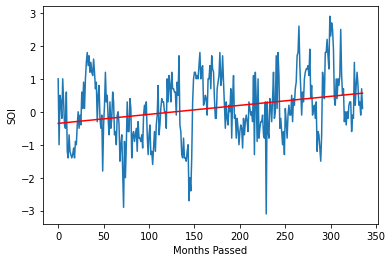

In [15]:
sfig, ax1 = pl.subplots()
fig.suptitle('SOI over Time NZ')
ax1.set_xlabel('Months Passed')
ax1.set_ylabel('SOI')
pl.plot(oscillation_data.SOI)
m, b = np.polyfit(oscillation_data.index, oscillation_data.SOI, 1)
pl.plot(oscillation_data.index, m*(oscillation_data.index) + b, 'r')
print(np.corrcoef(oscillation_data.index, oscillation_data.SOI)[0, 1])

A small positive trend appears in graph of data. correlation coefficient of possitive 0.27 (2dp) suppoers this with a weak positive association between number of months pass and SOI index. Although there is obvious temporal pattern (some months are lower than their preceeding months SIO), generally there is an increase in SOI over time (getting stronger)